In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


# MNISTデータの読み込み
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# データの前処理
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

# モデルの構築
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# モデルの学習
model.fit(x_train, y_train, epochs=5, validation_split=0.2)

# テストデータでCNNの性能を評価
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/5
1500/1500 [==============================] - 15s 10ms/step - loss: 0.1634 - accuracy: 0.9480 - val_loss: 0.0708 - val_accuracy: 0.9788
Epoch 2/5
1500/1500 [==============================] - 14s 9ms/step - loss: 0.0500 - accuracy: 0.9836 - val_loss: 0.0637 - val_accuracy: 0.9816
Epoch 3/5
1500/1500 [==============================] - 14s 9ms/step - loss: 0.0340 - accuracy: 0.9889 - val_loss: 0.0330 - val_accuracy: 0.9907
Epoch 4/5
1500/1500 [==============================] - 15s 10ms/step - loss: 0.0263 - accuracy: 0.9919 - val_loss: 0.0555 - val_accuracy: 0.9849
Epoch 5/5
1500/1500 [==============================] - 18s 12ms/step - loss: 0.0210 - accuracy: 0.9931 - val_loss: 0.0315 - val_accuracy: 0.9913
Test loss: 0.027242889627814293
Test accuracy: 0.9926000237464905


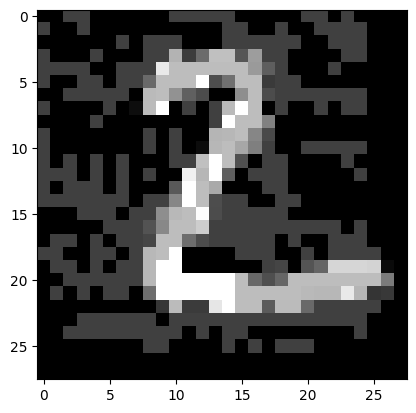

In [2]:
def fgsm_attack(image, epsilon, data_grad):
    perturbed_image = image + epsilon * data_grad
    perturbed_image = np.clip(perturbed_image, 0, 1)
    return perturbed_image

def generate_adversarial_examples(model, images, labels, epsilon=0.01):
    images = tf.convert_to_tensor(images)
    labels = tf.convert_to_tensor(labels)

    with tf.GradientTape() as tape:
        tape.watch(images)
        predictions = model(images)
        loss = keras.losses.sparse_categorical_crossentropy(labels, predictions)

    gradient = tape.gradient(loss, images)
    gradient_sign = tf.sign(gradient)
    adv_images = fgsm_attack(images, epsilon, gradient_sign)

    return adv_images  # .numpy()メソッド不要

# テストデータに対する敵対的攻撃の実行
epsilon = 0.25
adversarial_images = generate_adversarial_examples(model, x_test, y_test, epsilon)

# 結果の可視化
plt.imshow(np.squeeze(adversarial_images[1]), cmap='gray') 

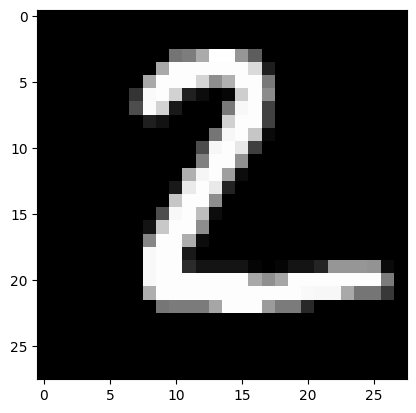

In [3]:
plt.imshow(np.squeeze(x_test[1]), cmap='gray')

In [4]:
#元の画像の成功率
test_loss, test_acc =model.evaluate(x_test, y_test)  

313/313 [==============================] - 2s 5ms/step - loss: 0.0272 - accuracy: 0.9926


In [5]:
#FGSMの成功率
fgsm_loss, fgsm_acc =model.evaluate(adversarial_images, y_test)  

313/313 [==============================] - 2s 5ms/step - loss: 2.6702 - accuracy: 0.3513


In [6]:
np.save('./adversarial_images.npy', adversarial_images)

In [7]:
cdcgan_img = np.load("cdcgan_imgs.npy")
cdcgan_label = np.load("cdcgan_labels.npy")

In [8]:
cdcgan_img.shape

(10000, 28, 28, 1)

In [9]:
cdcgan_label=np.argmax(cdcgan_label,axis=1)
cdcgan_label.shape

(10000,)

In [10]:
#CDCGANの成功率
test_loss, test_acc =model.evaluate(cdcgan_img, cdcgan_label) 

313/313 [==============================] - 2s 5ms/step - loss: 0.3429 - accuracy: 0.9217
